<a href="https://colab.research.google.com/github/morenov5/Graph-Neural-Networks-for-Predicting-Mechanical-Properties-of-Aerospace-Polymers/blob/main/Project_ISCMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0: Val loss = 1.0045
Epoch 10: Val loss = 0.0196
Epoch 20: Val loss = 0.0145
Epoch 30: Val loss = 0.0114
Epoch 40: Val loss = 0.0114
Epoch 50: Val loss = 0.0112
Epoch 60: Val loss = 0.0112
Epoch 70: Val loss = 0.0111
Epoch 80: Val loss = 0.0111
Epoch 90: Val loss = 0.0111

--- Final Results ---
Estimated density: 1.201 g/cm³
Base elastic modulus E₀ (target ~2 GPa): 2.000 GPa
Test RMSE: 0.1056 GPa
Test R²: 0.9915


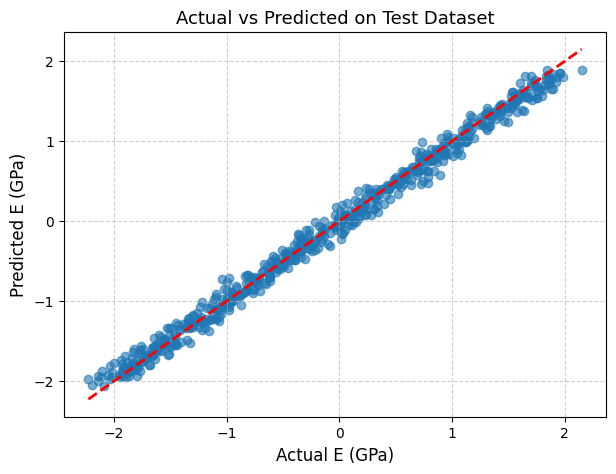

In [7]:
!pip install torch-geometric
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import mean_squared_error, r2_score


# Plot style
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 13,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'figure.figsize': (7, 5),
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'axes.edgecolor': 'black'
})


def build_polymer_dataset(monomer_name='Kevlar', n_units=30, num_samples=300):
    periodic_table = {
        'C':  [12.01, 0.77, 2.55, 1e4],
        'H':  [1.008, 0.32, 2.20, 1e-2],
        'O':  [16.00, 0.73, 3.44, 1e-6],
        'N':  [14.01, 0.75, 3.04, 1e-6],
        'Si': [28.09, 1.11, 1.90, 1.5e-3],
        'F':  [18.99, 0.57, 3.98, 1e-10],
        'Cl': [35.45, 0.99, 3.16, 1e-4]
    }

    monomers = {
        'PE': ['C','H','H','H','C','H','H','H'],
        'Nylon6': ['C','C','C','C','C','N','O'],
        'Kevlar': ['C','C','C','C','C','N','O']
    }

    monomer_volumes = {
        'PE': 28.0,
        'Nylon6': 60.0,
        'Kevlar': 75.0
    }

    base_atoms = monomers.get(monomer_name)
    if base_atoms is None:
        raise ValueError(f"Monómero '{monomer_name}' no reconocido. Opciones: {list(monomers.keys())}")

    polymer_atoms = base_atoms * n_units

    n_atoms = len(polymer_atoms)

    # Total mass (g/mol)
    total_mass = sum(periodic_table[atom][0] for atom in polymer_atoms)

    # Estimated total volume (cm³)
    total_volume_cm3 = monomer_volumes.get(monomer_name, 50) * n_units

    density = total_mass / total_volume_cm3  # g/cm³
    avg_mass = total_mass / n_atoms
    avg_radius = np.mean([periodic_table[atom][1] for atom in polymer_atoms])
    elastic_modulus_base = 0.01 * (avg_mass**2) / (avg_radius + 1e-6)
    E0 = 2.0  # GPa

    samples = []
    for _ in range(num_samples):
        T = np.random.uniform(20, 100)
        S = np.random.uniform(0, 200)
        E = E0 * (1 - 1e-3*(T - 20) - 1e-2*S)
        E += np.random.normal(scale=0.05 * E0)

        x = torch.tensor([[periodic_table[a][0], periodic_table[a][1]] for a in polymer_atoms], dtype=torch.float)

        edge_index = torch.tensor(
            [[i, i + 1] for i in range(n_atoms - 1)] + [[i + 1, i] for i in range(n_atoms - 1)],
            dtype=torch.long
        ).t()

        t = torch.tensor([T, S], dtype=torch.float).unsqueeze(0)
        y = torch.tensor([E], dtype=torch.float)
        batch = torch.zeros(x.size(0), dtype=torch.long)

        samples.append(Data(x=x, edge_index=edge_index, y=y, t=t, batch=batch))

    return samples, E0, density

class PolymerGNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(2,64)
        self.conv2 = GCNConv(64,64)
        self.fc = nn.Sequential(
            nn.Linear(64+2,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,1)
        )
    def forward(self, data):
        h = torch.relu(self.conv1(data.x, data.edge_index))
        h = torch.relu(self.conv2(h, data.edge_index))
        hg = global_mean_pool(h, data.batch)
        t = (data.t - torch.tensor([60.0,100.0], device=hg.device)) / torch.tensor([40.0,100.0], device=hg.device)
        return self.fc(torch.cat([hg, t], dim=1))

def train_and_evaluate(monomer='Kevlar'):
    samples, E0, density = build_polymer_dataset(monomer, n_units=30, num_samples=3000)
    train, test = samples[:2400], samples[2400:]
    train_loader = DataLoader(train, batch_size=32, shuffle=True)
    test_loader = DataLoader(test, batch_size=32, shuffle=False)

    model = PolymerGNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    loss_fn = nn.MSELoss()

    for epoch in range(100):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = loss_fn(pred.view(-1), batch.y.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
        val_loss = 0
        all_preds, all_y = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_loss += loss_fn(pred.view(-1), batch.y.to(device)).item() * batch.num_graphs
                all_preds.extend(pred.view(-1).cpu().numpy())
                all_y.extend(batch.y.cpu().numpy())
        scheduler.step(val_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Val loss = {val_loss/len(test):.4f}")

    y_pred, y_true = np.array(all_preds), np.array(all_y)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print("\n--- Final Results ---")
    print(f"Estimated density: {density:.3f} g/cm³")
    print(f"Base elastic modulus E₀ (target ~2 GPa): {E0:.3f} GPa")
    print(f"Test RMSE: {rmse:.4f} GPa")
    print(f"Test R²: {r2:.4f}")

    # Plot actual vs predicted
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual E (GPa)')
    plt.ylabel('Predicted E (GPa)')
    plt.title('Actual vs Predicted on Test Dataset')
    plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if __name__ == "__main__":
    train_and_evaluate('Kevlar')
